In [2]:
from datetime import datetime
import math
import cv2
import glob
import numpy as np
from numpy import zeros, ones, vstack, hstack
from numpy.random import permutation
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from skimage.metrics import structural_similarity as ssim

In [4]:
print(os.listdir("/kaggle/input/intel-image-classification/seg_pred"))

['seg_pred']


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
def RGB2LAB2(R0, G0, B0):
    R = R0 / 255
    G = G0 / 255
    B = B0 / 255

    Y = 0.299*R + 0.587*G + 0.114*B
    X = 0.449*R + 0.353*G + 0.198*B
    Z = 0.012*R + 0.089*G + 0.899*B

    L = Y
    a = (X - Y) / 0.234
    b = (Y - Z) / 0.785

    return L, a, b


def LAB22RGB(L, a, b):
    a11 = 0.299
    a12 = 0.587
    a13 = 0.114
    a21 = (0.15/0.234)
    a22 = (-0.234/0.234)
    a23 = (0.084/0.234)
    a31 = (0.287/0.785)
    a32 = (0.498/0.785)
    a33 = (-0.785/0.785)

    aa = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
    C0 = np.zeros((L.shape[0], 3))
    C0[:, 0] = L[:, 0]
    C0[:, 1] = a[:, 0]
    C0[:, 2] = b[:, 0]
    C = np.transpose(C0)

    X = np.linalg.inv(aa).dot(C)
    X1D = np.reshape(X, (X.shape[0]*X.shape[1], 1))
    p0 = np.where(X1D < 0)
    X1D[p0[0]] = 0
    p1 = np.where(X1D > 1)
    X1D[p1[0]] = 1
    Xr = np.reshape(X1D, (X.shape[0], X.shape[1]))

    Rr = Xr[0][:]
    Gr = Xr[1][:]
    Br = Xr[2][:]

    R = np.uint8(np.round(Rr * 255))
    G = np.uint8(np.round(Gr * 255))
    B = np.uint8(np.round(Br * 255))
    return R, G, B

In [7]:
def psnr(img1, img2):
    mse = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def mse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def mae(imageA, imageB, bands):
    err = np.sum(np.abs((imageA.astype("float") - imageB.astype("float"))))
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    return err

def rmse(imageA, imageB, bands):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1] * bands)
    err = np.sqrt(err)
    return err

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class TripleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TripleConv, self).__init__()
        self.triple_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.triple_conv(x)

In [ ]:
class UNet1(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(UNet1, self).__init__()

        # Encoder
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = TripleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = TripleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = TripleConv(512, 512)
        self.pool5 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv55 = TripleConv(512, 512)

        # Decoder
        self.up66 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv66 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up6 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(1024, 512)  # 512 + 512 from skip connection

        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(512, 256)  # 256 + 256 from skip connection

        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = DoubleConv(256, 128)  # 128 + 128 from skip connection

        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = DoubleConv(128, 64)  # 64 + 64 from skip connection

        # Multi-scale feature fusion
        self.up_f02 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.up_f12 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Final layers
        self.conv11 = nn.Conv2d(384, 128, kernel_size=3, padding=1)  # 64+64+128+128
        self.relu11 = nn.ReLU(inplace=True)

        self.conv12 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.relu12 = nn.ReLU(inplace=True)

        self.conv13 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu13 = nn.ReLU(inplace=True)

        self.conv14 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        x1 = self.pool1(conv1)

        conv2 = self.conv2(x1)
        x2 = self.pool2(conv2)

        conv3 = self.conv3(x2)
        x3 = self.pool3(conv3)

        conv4 = self.conv4(x3)
        x4 = self.pool4(conv4)

        conv5 = self.conv5(x4)
        x5 = self.pool5(conv5)

        # Bottleneck
        conv55 = self.conv55(x5)

        # Decoder
        up66 = self.up66(conv55)
        if up66.size()[2:] != conv5.size()[2:]:
            up66 = F.interpolate(up66, size=conv5.size()[2:], mode="bilinear", align_corners=True)
        merge66 = torch.cat([conv5, up66], dim=1)
        conv66 = self.conv66(merge66)

        up6 = self.up6(conv66)
        if up6.size()[2:] != conv4.size()[2:]:
            up6 = F.interpolate(up6, size=conv4.size()[2:], mode="bilinear", align_corners=True)
        merge6 = torch.cat([conv4, up6], dim=1)
        conv6 = self.conv6(merge6)

        up7 = self.up7(conv6)
        if up7.size()[2:] != conv3.size()[2:]:
            up7 = F.interpolate(up7, size=conv3.size()[2:], mode="bilinear", align_corners=True)
        merge7 = torch.cat([conv3, up7], dim=1)
        conv7 = self.conv7(merge7)

        up8 = self.up8(conv7)
        if up8.size()[2:] != conv2.size()[2:]:
            up8 = F.interpolate(up8, size=conv2.size()[2:], mode="bilinear", align_corners=True)
        merge8 = torch.cat([conv2, up8], dim=1)
        conv8 = self.conv8(merge8)

        up9 = self.up9(conv8)
        if up9.size()[2:] != conv1.size()[2:]:
            up9 = F.interpolate(up9, size=conv1.size()[2:], mode="bilinear", align_corners=True)
        merge9 = torch.cat([conv1, up9], dim=1)
        conv9 = self.conv9(merge9)


        # Multi-scale feature fusion
        up_f01 = conv1  
        up_f11 = conv9  
        up_f02 = self.up_f02(conv2)  
        up_f12 = self.up_f12(conv8)  

        # Concatenate multi-scale features
        merge11 = torch.cat([up_f01, up_f11, up_f02, up_f12], dim=1)

        # Final processing
        conv11 = self.relu11(self.conv11(merge11))
        conv12 = self.relu12(self.conv12(conv11))
        conv13 = self.relu13(self.conv13(conv12))
        output = self.tanh(self.conv14(conv13))

        return output

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, file_list, dim=150):
        self.file_list = file_list
        self.dim = dim

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.dim, self.dim))

        # Convert to LAB2
        sz0, sz1 = img.shape[:2]
        R1 = img[:, :, 0].reshape(-1, 1)
        G1 = img[:, :, 1].reshape(-1, 1)
        B1 = img[:, :, 2].reshape(-1, 1)

        L, A, B = RGB2LAB2(R1, G1, B1)

        L = L.reshape(sz0, sz1, 1)
        A = A.reshape(sz0, sz1)
        B = B.reshape(sz0, sz1)

        ab = np.stack([A, B], axis=2)

        # Convert to tensors and normalize
        L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)
        ab_tensor = torch.FloatTensor(ab).permute(2, 0, 1)  # (2, H, W)

        return L_tensor, ab_tensor


In [ ]:
def load_vgg16_weights(model):
    vgg16 = models.vgg16(pretrained=True).to(device)
    vgg_features = vgg16.features

    with torch.no_grad():
        # Get original RGB weights
        rgb_weights = vgg_features[0].weight  # Shape: (64, 3, 3, 3)
        # Average across RGB channels
        gray_weights = rgb_weights.mean(dim=1, keepdim=True)  # Shape: (64, 1, 3, 3)

        # Set weights for first layer
        model.conv1.double_conv[0].weight.data = gray_weights
        model.conv1.double_conv[0].bias.data = vgg_features[0].bias.data

        # Set weights for second conv in first block
        model.conv1.double_conv[2].weight.data = vgg_features[2].weight.data
        model.conv1.double_conv[2].bias.data = vgg_features[2].bias.data

        # Second block
        model.conv2.double_conv[0].weight.data = vgg_features[5].weight.data
        model.conv2.double_conv[0].bias.data = vgg_features[5].bias.data
        model.conv2.double_conv[2].weight.data = vgg_features[7].weight.data
        model.conv2.double_conv[2].bias.data = vgg_features[7].bias.data

        # Third block (first two convs)
        model.conv3.triple_conv[0].weight.data = vgg_features[10].weight.data
        model.conv3.triple_conv[0].bias.data = vgg_features[10].bias.data
        model.conv3.triple_conv[2].weight.data = vgg_features[12].weight.data
        model.conv3.triple_conv[2].bias.data = vgg_features[12].bias.data
        model.conv3.triple_conv[4].weight.data = vgg_features[14].weight.data
        model.conv3.triple_conv[4].bias.data = vgg_features[14].bias.data

        # Fourth block
        model.conv4.triple_conv[0].weight.data = vgg_features[17].weight.data
        model.conv4.triple_conv[0].bias.data = vgg_features[17].bias.data
        model.conv4.triple_conv[2].weight.data = vgg_features[19].weight.data
        model.conv4.triple_conv[2].bias.data = vgg_features[19].bias.data
        model.conv4.triple_conv[4].weight.data = vgg_features[21].weight.data
        model.conv4.triple_conv[4].bias.data = vgg_features[21].bias.data

        # Fifth block
        model.conv5.triple_conv[0].weight.data = vgg_features[24].weight.data
        model.conv5.triple_conv[0].bias.data = vgg_features[24].bias.data
        model.conv5.triple_conv[2].weight.data = vgg_features[26].weight.data
        model.conv5.triple_conv[2].bias.data = vgg_features[26].bias.data
        model.conv5.triple_conv[4].weight.data = vgg_features[28].weight.data
        model.conv5.triple_conv[4].bias.data = vgg_features[28].bias.data


In [ ]:
def train_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    dim = 150
    batch_size = 16
    epochs_max = 10
    max_nb_min = 3

    cwd = os.getcwd()

    # base_path = "/content/drive/MyDrive/Intel Image/seg_train/seg_train"
    base_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
    classes = os.listdir(base_path)

    image_paths = []

    for cls in classes:
        folder_path = os.path.join(base_path, cls, "*.jpg")
        for file in glob.glob(folder_path):
            image_paths.append(file)

    print("Number of training images:", len(image_paths))

    # Create model
    model = UNet1(in_channels=1, out_channels=2).to(device)

    print('Loading VGG16 pretrained weights...')
    load_vgg16_weights(model)

    # Loss function and optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Create dataset and dataloader
    dataset = ColorizationDataset(image_paths, dim=dim)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Training tracking
    tr_acc = np.zeros((epochs_max, 2))
    time_tr = np.zeros((epochs_max, 2))
    mae_min = float('inf')
    nb_min = 0
    stop = 0

    print('Starting training...')

    for epoch in range(epochs_max):
        if stop:
            break

        start_time = datetime.now()
        model.train()

        total_loss = 0.0
        num_batches = 0

        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.6f}')

        avg_loss = total_loss / num_batches

        # Update tracking arrays
        tr_acc[epoch, 0] = epoch
        tr_acc[epoch, 1] = avg_loss

        end_time = datetime.now()
        time_diff = end_time - start_time
        time_tr[epoch, 0] = epoch
        time_tr[epoch, 1] = time_diff.seconds

        print(f'Epoch {epoch+1}/{epochs_max}, Average Loss: {avg_loss:.6f}, Time: {time_diff.seconds}s')

        # Early stopping logic
        if avg_loss > mae_min:
            nb_min += 1
        else:
            mae_min = avg_loss
            nb_min = 0
            # Save best model
            torch.save(model.state_dict(), os.path.join(cwd, 'Hyper_U_NET_pytorch.pth'))
            print(f'New best model saved with loss: {mae_min:.6f}')

        if nb_min > max_nb_min:
            stop = 1
            print('Early stopping triggered')

        # Learning rate scheduling (same as original)
        if epoch + 1 == 1:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-5
        elif epoch + 1 == 2:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-5
        elif epoch + 1 == 4:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-5
        elif epoch + 1 == 8:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-6
        elif epoch + 1 == 16:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-6
        elif epoch + 1 == 32:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-6
        elif epoch + 1 == 64:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 5e-7
        elif epoch + 1 == 128:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 2e-7
        elif epoch + 1 == 256:
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-7

        # Save progress
        np.save(os.path.join(cwd, 'tr_Acc_Hyper_U_NET_pytorch.npy'), tr_acc)
        np.save(os.path.join(cwd, 'Tr_runtime_Hyper_U_NET_pytorch.npy'), time_tr)



In [ ]:
def load_model_for_inference(model_path, device):
    model = UNet1(in_channels=1, out_channels=2).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def inference(model, l_channel):
    model.eval()
    with torch.no_grad():
        if len(l_channel.shape) == 3:
            l_channel = l_channel.unsqueeze(0)  # Add batch dimension

        l_tensor = torch.FloatTensor(l_channel).to(device)
        ab_pred = model(l_tensor)

        return ab_pred.cpu().numpy()

In [ ]:
if __name__ == "__main__":
    train_model()

Number of training images: 14034
Loading VGG16 pretrained weights...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]  


Starting training...
Epoch 1, Batch 0/878, Loss: 0.069138
Epoch 1, Batch 10/878, Loss: 0.064785
Epoch 1, Batch 20/878, Loss: 0.062118
Epoch 1, Batch 30/878, Loss: 0.054113
Epoch 1, Batch 40/878, Loss: 0.057871
Epoch 1, Batch 50/878, Loss: 0.054442
Epoch 1, Batch 60/878, Loss: 0.049861
Epoch 1, Batch 70/878, Loss: 0.047647
Epoch 1, Batch 80/878, Loss: 0.057870
Epoch 1, Batch 90/878, Loss: 0.051483
Epoch 1, Batch 100/878, Loss: 0.068442
Epoch 1, Batch 110/878, Loss: 0.046759
Epoch 1, Batch 120/878, Loss: 0.049723
Epoch 1, Batch 130/878, Loss: 0.050535
Epoch 1, Batch 140/878, Loss: 0.054275
Epoch 1, Batch 150/878, Loss: 0.049744
Epoch 1, Batch 160/878, Loss: 0.056619
Epoch 1, Batch 170/878, Loss: 0.057104
Epoch 1, Batch 180/878, Loss: 0.049791
Epoch 1, Batch 190/878, Loss: 0.064581
Epoch 1, Batch 200/878, Loss: 0.039769
Epoch 1, Batch 210/878, Loss: 0.061259
Epoch 1, Batch 220/878, Loss: 0.070065
Epoch 1, Batch 230/878, Loss: 0.044150
Epoch 1, Batch 240/878, Loss: 0.039660
Epoch 1, Batch 

### Testing Model

In [19]:
model_path = "/kaggle/working/Hyper_U_NET_pytorch.pth"
test_model = load_model_for_inference(model_path, device)

In [ ]:
def prepare_test_image(img_path, dim=150):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (dim, dim))

    sz0, sz1 = img.shape[:2]
    R1 = img[:, :, 0].reshape(-1, 1)
    G1 = img[:, :, 1].reshape(-1, 1)
    B1 = img[:, :, 2].reshape(-1, 1)

    L, A, B = RGB2LAB2(R1, G1, B1)
    L = L.reshape(sz0, sz1, 1)

    L_tensor = torch.FloatTensor(L).permute(2, 0, 1)  # (1, H, W)

    return L_tensor, A.reshape(sz0, sz1), B.reshape(sz0, sz1)


In [ ]:
l_tensor, A_true, B_true = prepare_test_image("/kaggle/input/intel-image-classification/seg_pred/seg_pred/10034.jpg", dim=150)

ab_pred = inference(test_model, l_tensor)  
ab_pred = ab_pred.squeeze(0)         
A_pred, B_pred = ab_pred[0], ab_pred[1]

sz0, sz1 = A_pred.shape
L = l_tensor.squeeze().numpy().reshape(-1,1)
A = A_pred.reshape(-1,1)
B = B_pred.reshape(-1,1)

R, G, B = LAB22RGB(L, A, B)
R = R.reshape(sz0, sz1)
G = G.reshape(sz0, sz1)
B = B.reshape(sz0, sz1)

rgb_pred = cv2.merge([R,G,B])


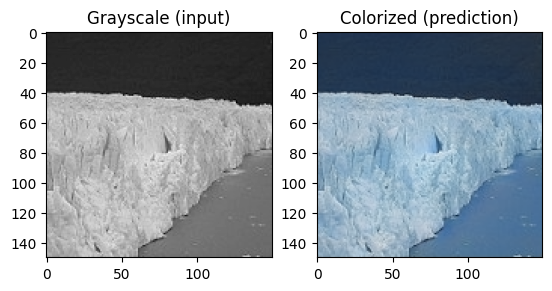

In [37]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.title("Grayscale (input)")
plt.imshow(l_tensor.squeeze(0).numpy(), cmap="gray")

plt.subplot(1,2,2)
plt.title("Colorized (prediction)")
plt.imshow(cv2.cvtColor(rgb_pred, cv2.COLOR_BGR2RGB))

plt.show()
